### Budget of oxygen in rho2 diagnostic grid
This provides the simplest perspective of the biogeochemical cycle of oxygen as a function of density - not necessary to consider WMT etc.

In [23]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import budgetcalcs as bc

In [24]:
rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/history/'
filename = '08500101.ocean_month_rho2.nc'
ds = xr.open_dataset(rootdir+filename)
filename_grid = '08500101.ocean_static_no_mask_table.nc'
grid = xr.open_dataset(rootdir+filename_grid)
# Name of vertical coordinate
vertc = 'rho2_l'

o2_terms = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap','o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2_plus_btm']
o2_tend = o2_terms[0]
# Correct MOM6 tendencies to account for mass in cell
# i.e. convert from [mol kg^-1 m s^-1] to [mol m^-2 s^-1]
rho0=1035.0
for term in o2_terms[:-1]:
    ds[term] *= rho0

# Take only o2 budget terms from dataset
ds = ds[o2_terms]

# Remove bottom boundary flux from jo2_plus_btm (already included in o2_vdiffuse_impl)
# jo2_btm = xr.zeros_like(ds.jo2_plus_btm)
# jo2_btm.loc[dict(zl=ds.zl.max())]=ds.o2_btf
# jo2 = ds.jo2_plus_btm - jo2_btm
# ds['jo2'] = jo2

/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


In [25]:
# Integrate tendencies within each layer
prof = (ds*grid.areacello).sum(dim=['xh','yh']).squeeze()

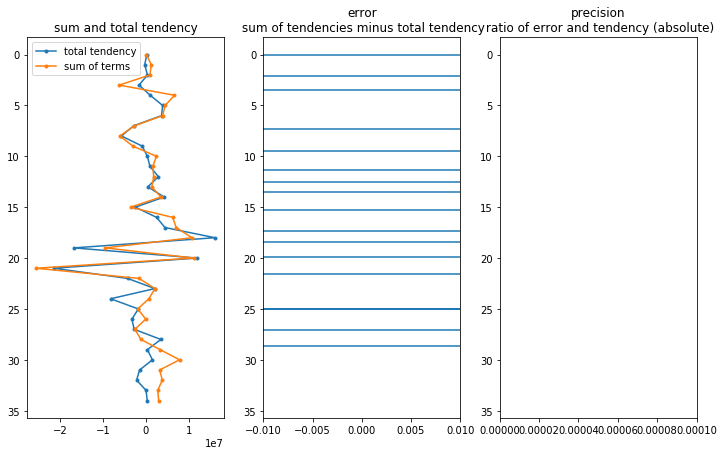

In [26]:
tendsum, error = bc.calc_budget(prof,o2_terms[1:],o2_terms[0],vertc=vertc,errors=[-1E-2,1E-2]);

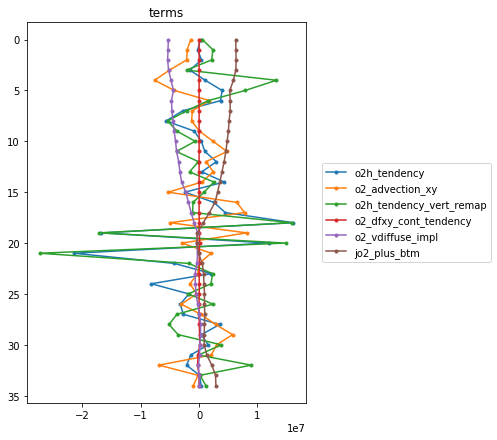

In [27]:
bc.plot_budgetterms(prof,o2_terms,vertc=vertc);

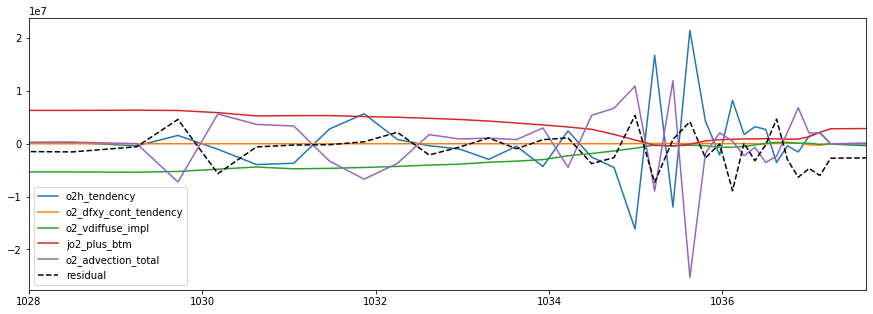

In [29]:
prof['o2_advection_total'] = prof['o2_advection_xy']+prof['o2h_tendency_vert_remap']
indices = [0,3,4,5]
o2_terms_new = [o2_terms[i] for i in indices]
o2_terms_new.append('o2_advection_total')
fig,ax = plt.subplots(figsize=(15,5))
for term in o2_terms_new:
    if term==o2_tend:
        ax.plot(prof[vertc],-1*prof[o2_tend],label=term)
    else:
        ax.plot(prof[vertc],prof[term],label=term)
ax.plot(prof[vertc],error,'k--',label='residual')
ax.legend()
if vertc=='zl':
    ax.set_xlim([0,1000])
elif vertc=='rho2_l':
    ax.set_xlim([1028,prof[vertc].max()]);